# To save uncertainty results for downstream task

In [1]:
RUN_ID = 40 # mean t1gd
RANDOM_SEED = 0
ROOT_DIR = "/scratch1/sachinsa/cont_syn"

In [2]:
import os
import pandas as pd

import pdb
import numpy as np
from utils.logger import Logger

import torch
from torch.utils.data import DataLoader

from utils.model import create_UNet3D, inference
from utils.transforms import contr_syn_transform_2 as data_transform
from utils.dataset import BraTSDataset

logger = Logger(log_level='DEBUG')

[INFO] Logging level is: DEBUG


In [3]:
save_dir = os.path.join('/scratch1/sachinsa/data/contr_generated', f"run_{RUN_ID}")
os.makedirs(save_dir, exist_ok=True)

In [4]:
input_filter = [0,1,3]

In [5]:
device = torch.device("cuda:0")
out_channels = 1
model = create_UNet3D(len(input_filter), out_channels, device)

In [6]:
all_dataset = BraTSDataset(
    version='2017',
    section='all',
    seed = RANDOM_SEED,
    transform = data_transform['val']
)
all_loader = DataLoader(all_dataset, batch_size=1, shuffle=False, num_workers=8)

In [33]:
# temp code: create mean t1gd

t1gd_tensor = torch.zeros([1, 1, 240, 240, 155], device=device)

ix = 0
with torch.no_grad():
    for this_data in all_loader:
        this_inputs, this_ids = (
            this_data["image"].to(device),
            this_data["id"],
        )
        this_inputs = this_inputs[:,[2], ...]
        t1gd_tensor += this_inputs
        ix += 1
        if ix > 100: break

t1gd_tensor /= ix

sum: 1596.91064453125


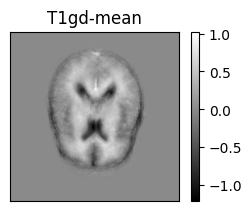

In [34]:
from utils.plot import brain_plot

brain_plot(t1gd_tensor, ["T1gd-mean"])

In [36]:
import nibabel as nib

In [ ]:
with torch.no_grad():
    for this_data in all_loader:
        this_inputs, this_ids = (
            this_data["image"].to(device),
            this_data["id"],
        )
        this_inputs = this_inputs[:,input_filter, ...]
        this_combined = torch.cat([this_inputs[:, :2, ...], t1gd_tensor, this_inputs[:, 2:, ...]], dim=1)
        
        mri_array = this_combined[0].detach().permute(1, 2, 3, 0).cpu().numpy()
        nifti_img = nib.Nifti1Image(mri_array,affine=np.eye(4))
        output_filename = os.path.join(save_dir, f'BRATS_{this_ids[0]:03d}.nii.gz')
        print(output_filename)
        nib.save(nifti_img, output_filename)

/scratch1/sachinsa/data/contr_generated/run_40/BRATS_457.nii.gz
/scratch1/sachinsa/data/contr_generated/run_40/BRATS_306.nii.gz
/scratch1/sachinsa/data/contr_generated/run_40/BRATS_206.nii.gz
/scratch1/sachinsa/data/contr_generated/run_40/BRATS_449.nii.gz
/scratch1/sachinsa/data/contr_generated/run_40/BRATS_318.nii.gz


In [50]:
load_dir = os.path.join(ROOT_DIR, f"run_{RUN_ID}")
checkpoint = torch.load(os.path.join(load_dir, 'best_checkpoint.pth'), weights_only=True)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
channels = ["FLAIR", "T1w", "T1Gd", "T2w"]

In [51]:
with torch.no_grad():
    for this_data in all_loader:
        this_inputs, this_ids = (
            this_data["image"].to(device),
            this_data["id"],
        )
        this_inputs = this_inputs[:,input_filter, ...]
        this_outputs = inference(this_inputs, model)
        this_combined = torch.cat([this_inputs[:, :2, ...], this_outputs, this_inputs[:, 2:, ...]], dim=1)
        
        mri_array = this_combined[0].detach().permute(1, 2, 3, 0).cpu().numpy()
        nifti_img = nib.Nifti1Image(mri_array,affine=np.eye(4))
        output_filename = os.path.join(save_dir, f'BRATS_{this_ids[0]:03d}.nii.gz')
        print(output_filename)
        nib.save(nifti_img, output_filename)

/scratch1/sachinsa/data/contr_generated/run_32/BRATS_457.nii.gz
/scratch1/sachinsa/data/contr_generated/run_32/BRATS_306.nii.gz
/scratch1/sachinsa/data/contr_generated/run_32/BRATS_206.nii.gz
/scratch1/sachinsa/data/contr_generated/run_32/BRATS_449.nii.gz
/scratch1/sachinsa/data/contr_generated/run_32/BRATS_318.nii.gz
/scratch1/sachinsa/data/contr_generated/run_32/BRATS_218.nii.gz
/scratch1/sachinsa/data/contr_generated/run_32/BRATS_434.nii.gz
/scratch1/sachinsa/data/contr_generated/run_32/BRATS_365.nii.gz
/scratch1/sachinsa/data/contr_generated/run_32/BRATS_265.nii.gz
/scratch1/sachinsa/data/contr_generated/run_32/BRATS_214.nii.gz
/scratch1/sachinsa/data/contr_generated/run_32/BRATS_314.nii.gz
/scratch1/sachinsa/data/contr_generated/run_32/BRATS_445.nii.gz
/scratch1/sachinsa/data/contr_generated/run_32/BRATS_269.nii.gz
/scratch1/sachinsa/data/contr_generated/run_32/BRATS_369.nii.gz
/scratch1/sachinsa/data/contr_generated/run_32/BRATS_438.nii.gz
/scratch1/sachinsa/data/contr_generated/